# LAB14 tutorial for Machine Learning <br > RNN
------

## Objective

- Understanding RNN.
- Be able to RNN with Pytorch.

------

## Introduction for RNN
### What is RNN?

The Recurrent Neural Network (RNN), is a sort of neural network that can process **sequential** data, which cannot be dealt with by previously introduced neural networks.

<img src="images/NN.png" alt="Neural network introduced before" style="zoom:25%;margin-left:auto;margin-right:auto">

The above traditional neural network can process traditional data. Each data sample has fixed number of features and they are assumed to be sampled independently and identically from some distribution.

But some times people need to deal with sequential data. People may want to translate "This is a tutorial of RNN" to other languages. Sequential data is different from other forms of data. That's why we need RNN (image from https://cs231n.github.io/rnn/):

<img src="images/rnn_blackbox.png" alt="RNN" style="zoom:25%;margin-left:auto;margin-right:auto">

The hidden layer of RNN is pointing to itself. 

### How RNN works?

Let's reveal the figure of RNN.

<img src="images/unrolledRNN.png" alt="RNN unrolled" style="zoom:25%;margin-left:auto;margin-right:auto">

The above figure shows how data follow when you put sequential data into the network (not exactly the structure of the network). Now suppose $x_1$ is a fixed length vector representing a word (one-hot encoding or word vector, see [word embeddings](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)). Give $x_1$ as the input of this network, calculate the hidden layer (green block), then calculate the output $y_1$ if necessary. After that, the next word $x_2$ is given as the input. Here is the difference: the hidden layer needs two inputs, $x_2$ and the hidden layer's previous state. This goes on until $x_t$ is processed and the network produce the output $y_t$.

For traditional neural network, the hidden layer of the network is calculated as:
$$
h=f(W \cdot x)
$$

For RNN, the hidden layer of the network is calculated as:
$$
h_t=f(W_h \cdot h_{t-1} + W_x \cdot x)
$$

We can use tanh or Relu as the activate function $f$.

RNN is has its application in many fields. The output of RNN can vary according to its purpose:

<img src="images/types.PNG" alt="types of RNN" style="zoom:25%;margin-left:auto;margin-right:auto">

## Example: name classification using RNN with pytorch

Now let's finish the exercise from [pytorch tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html).

In the data directory of lab material, we have a few txt files, each containing people's name from different coutries, one for each line. Out task is to train an RNN classifier: given a name, tell us which country this name belong to.

First of all is the data preprocessing:

In [1]:
import unicodedata
import string

# characters to deal with

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print('all_letters: ', all_letters)
print('n_letters: ', n_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print('Ślusàrski -> ', unicodeToAscii('Ślusàrski'))

all_letters:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_letters:  57
Ślusàrski ->  Slusarski


In [2]:
from io import open
import glob
import os

# Read all names and store as dictionary

category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob('data/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(all_categories)
print(category_lines['English'][:5])

['English', 'French', 'German', 'Greek', 'Portuguese', 'Spanish']
['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


In [3]:
import torch

# turn names to tensor

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters, device=device)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters, device=device)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0')
torch.Size([5, 1, 57])


In [4]:
from torch import nn

# instead of building your own RNN like in the pytorch tutorial, let's use the RNN class

class NameRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NameRNN, self).__init__()

        self.hidden_size = hidden_size

        self.rnn = nn.RNN(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.linear(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, device):
        return torch.zeros(1, self.hidden_size, device=device)

n_hidden = 128
name_rnn = NameRNN(n_letters, n_hidden, n_categories).to(device)

In [5]:
# before training, run some inference

input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden).to(device)

output, next_hidden = name_rnn(input[0], hidden)
print(output)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

tensor([[-1.7453, -1.7272, -1.7522, -1.8017, -1.8407, -1.8935]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('French', 1)


In [6]:
import random

# randomly sample

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, ', line =', line, ', category_tensor =', category_tensor)

category = Spanish , line = Ruiz , category_tensor = tensor([5])
category = German , line = Fried , category_tensor = tensor([2])
category = French , line = Salvage , category_tensor = tensor([1])
category = German , line = Hoch , category_tensor = tensor([2])
category = Portuguese , line = Machado , category_tensor = tensor([4])
category = Portuguese , line = Freitas , category_tensor = tensor([4])
category = German , line = Krantz , category_tensor = tensor([2])
category = English , line = Nilsen , category_tensor = tensor([0])
category = English , line = Innes , category_tensor = tensor([0])
category = French , line = Bouchard , category_tensor = tensor([1])


In [7]:
# define training process

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(name_rnn.parameters(),lr=learning_rate)

def train(name_rnn, category_tensor, line_tensor):
    hidden = name_rnn.initHidden(device)

    name_rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = name_rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    optimizer.step()

    return output, loss.item()

In [8]:
import time
import math

n_iters = 70000
print_every = 5000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(name_rnn, category_tensor.to(device), line_tensor.to(device))
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))


5000 7% (0m 22s) 1.3520 Arthur / German ✗ (French)
10000 14% (0m 44s) 0.2898 Huber / German ✓
15000 21% (1m 6s) 0.5419 Palmeiro / Portuguese ✓
20000 28% (1m 28s) 0.4168 Bauer / German ✓
25000 35% (1m 51s) 0.4118 Darlington / English ✓
30000 42% (2m 13s) 5.6541 Macrae / Portuguese ✗ (English)
35000 50% (2m 35s) 2.4308 Arthur / German ✗ (French)
40000 57% (2m 57s) 0.1237 Colbert / French ✓
45000 64% (3m 19s) 1.8247 Franke / French ✗ (German)
50000 71% (3m 41s) 0.1419 Almeida / Portuguese ✓
55000 78% (4m 3s) 0.0034 Karkampasis / Greek ✓
60000 85% (4m 25s) 0.0409 Neilson / English ✓
65000 92% (4m 47s) 0.2358 Sandoval / Spanish ✓
70000 100% (5m 10s) 0.8508 D'aramitz / French ✓


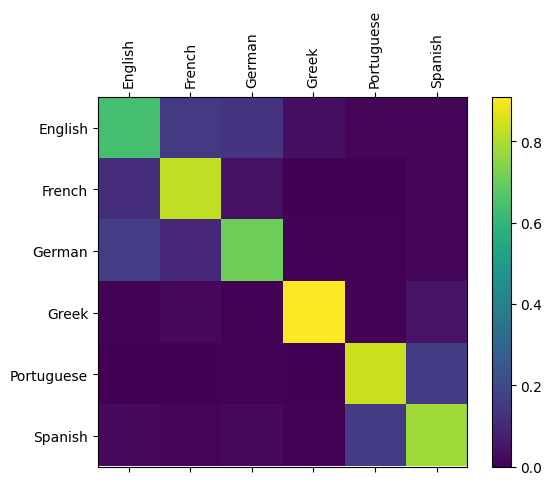

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Evaluation

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = name_rnn.initHidden(device)

    for i in range(line_tensor.size()[0]):
        output, hidden = name_rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticks(range(n_categories))
ax.set_xticklabels(all_categories, rotation=90)
ax.set_yticks(range(n_categories))
ax.set_yticklabels(all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()